In [29]:
import pandas as pd 
import re
CSV_PATH="../api_styles_all_in_one_text.csv"
database=pd.read_csv(CSV_PATH)
random_seed=47
database

,author,song_title,extracted_styles,input_tokens,output_tokens,total_tokens,ms
0,Петре М. Андреевски,Наопачно оро,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,1198,1132,2330,4619
1,Кочо Рацин,Балада за непознатиот,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,1860,1132,2992,5619
2,Гане Тодоровски,Молитва,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,1449,1132,2581,4924
3,Владо Урошевиќ,Слобода,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,1487,1132,2619,5278
4,Кочо Рацин,Копачите,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,2035,1132,3167,5703
...,...,...,...,...,...,...,...
1194,Ристо Лазаров,ЕВИТА,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,1550,1132,2682,4845
1195,Ристо Лазаров,ГАРДЕЛ,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,1509,1132,2641,4864
1196,Ристо Лазаров,БОРХЕС,Фигуративен јазик: Да\nСарказам: Не\nФрагмент ...,1446,1132,2578,4664
1197,Ристо Лазаров,САБАТО,Фигуративен јазик: Да \nСарказам: Не \nФрагм...,1506,1132,2638,4603


Person classification

In [6]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, make_scorer, confusion_matrix,accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import optuna

author_counts = database['author'].value_counts()
valid_authors = author_counts[author_counts >= 2].index
filtered_df = database[database['author'].isin(valid_authors)].reset_index(drop=True)

feature_vectors = []
for _, row in filtered_df.iterrows():
    values = [0] * 86
    pattern = r"(.+?):\s*(.+)"
    pairs = re.findall(pattern, row['extracted_styles'])
    for i, (key, value) in enumerate(pairs):
        if i >= 86:
            break
        if value.strip().lower().startswith("да"):
            values[i] = 1
    feature_vectors.append(values)

X = np.array(feature_vectors)
y = filtered_df['author']



[I 2025-10-15 18:47:31,794] A new study created in memory with name: no-name-38b96444-af0e-40cc-9e9a-e6328e4031ab
[I 2025-10-15 18:47:47,145] Trial 14 finished with value: 0.10926135354976511 and parameters: {'n_estimators': 77, 'max_depth': 3, 'learning_rate': 0.12338198588589416, 'subsample': 0.980231700002553, 'colsample_bytree': 0.6125063150288881}. Best is trial 14 with value: 0.10926135354976511.
[I 2025-10-15 18:47:49,457] Trial 0 finished with value: 0.07428763347697676 and parameters: {'n_estimators': 51, 'max_depth': 7, 'learning_rate': 0.011986167969782295, 'subsample': 0.7431960054428517, 'colsample_bytree': 0.6662459750683617}. Best is trial 14 with value: 0.10926135354976511.
[I 2025-10-15 18:47:55,612] Trial 12 finished with value: 0.11547987922229701 and parameters: {'n_estimators': 76, 'max_depth': 5, 'learning_rate': 0.11541498353906429, 'subsample': 0.8685276960458812, 'colsample_bytree': 0.903964354063525}. Best is trial 12 with value: 0.11547987922229701.
[I 2025-1

Best trial:
{'n_estimators': 151, 'max_depth': 6, 'learning_rate': 0.08102428698075485, 'subsample': 0.6955386577297793, 'colsample_bytree': 0.8151850584590561}
Accuracy: 0.30962343096234307
Macro F1 Score: 0.15941277358512085


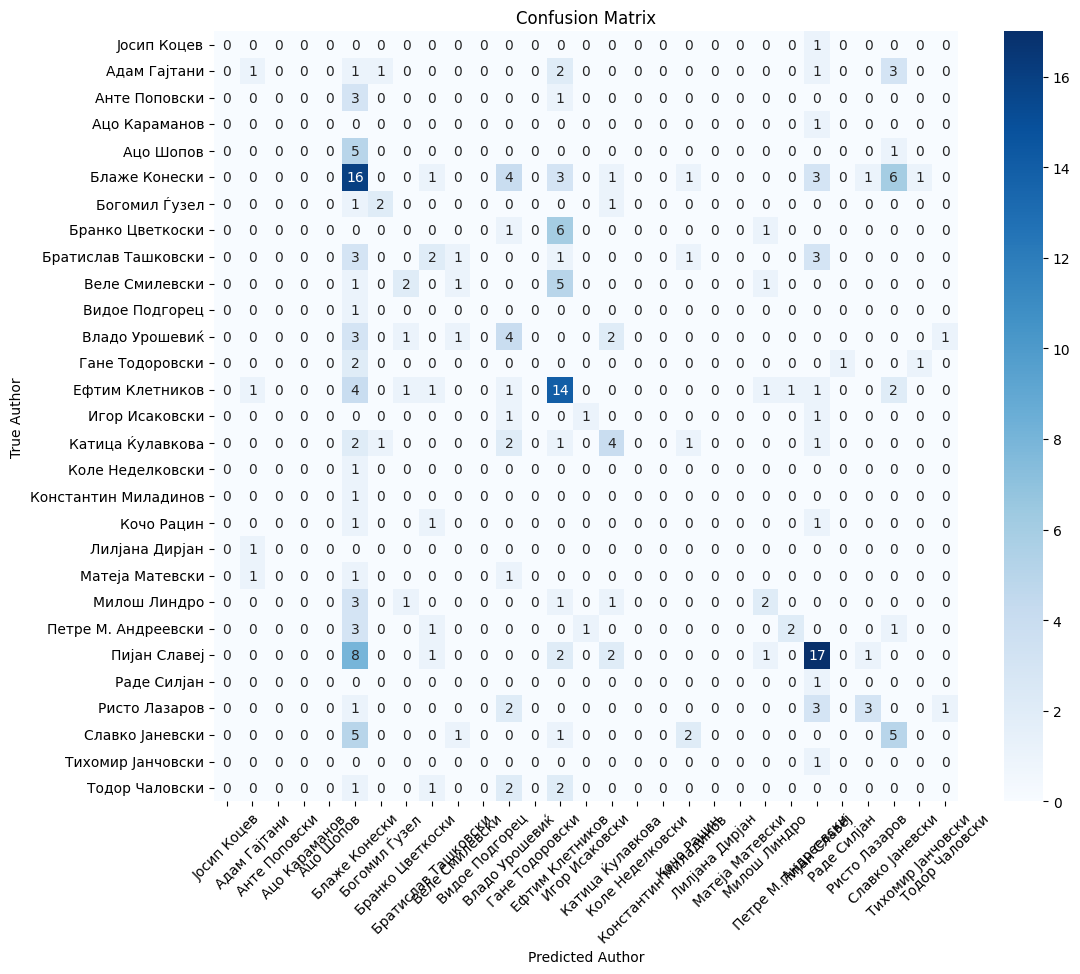

In [10]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
author_names = label_encoder.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
'subsample': trial.suggest_float('subsample', 0.6, 1.0),
'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'eval_metric': 'mlogloss',
        'num_class': len(author_names),
        'random_state': 47
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    scorer = make_scorer(f1_score, average='macro')
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_tr, y_tr,  eval_set=[(X_val, y_val)], verbose=False)
        y_val_pred = model.predict(X_val)
        f1_scores.append(f1_score(y_val, y_val_pred, average='macro'))
    return np.mean(f1_scores)
        

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1) 
print("Best trial:")
print(study.best_trial.params)


best_params = study.best_trial.params
best_params.update({'eval_metric': 'mlogloss', 'num_class': len(author_names), 'random_state': 47})
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc)
print("Macro F1 Score:", f1)

cm = confusion_matrix(y_test, y_pred)
present_classes_idx = np.unique(y_test)
author_labels = label_encoder.inverse_transform(present_classes_idx)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=author_labels, yticklabels=author_labels)
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

y_pred_authors = label_encoder.inverse_transform(y_pred)


Trying with a more balacned database

[I 2025-10-15 19:40:49,262] A new study created in memory with name: no-name-32342b0d-25f3-4515-b28e-46c8ce9ec30c
/tmp/ipykernel_204546/3110109429.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  limited_df = filtered.groupby('author').apply(
[I 2025-10-15 19:40:51,066] Trial 0 finished with value: 0.17319943392049653 and parameters: {'min_songs': 13, 'max_songs': 147, 'n_estimators': 195, 'max_depth': 6, 'learning_rate': 0.07460352958877593, 'subsample': 0.70116392827607, 'colsample_bytree': 0.9466467378028754}. Best is trial 0 with value: 0.17319943392049653.
/tmp/ipykernel_204546/3110109429.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is

Best parameters: {'min_songs': 30, 'max_songs': 79, 'n_estimators': 174, 'max_depth': 4, 'learning_rate': 0.07100990122562005, 'subsample': 0.8170442497158102, 'colsample_bytree': 0.8795527943642032}
Accuracy: 0.3067484662576687
Macro F1 Score: 0.27700669925953725


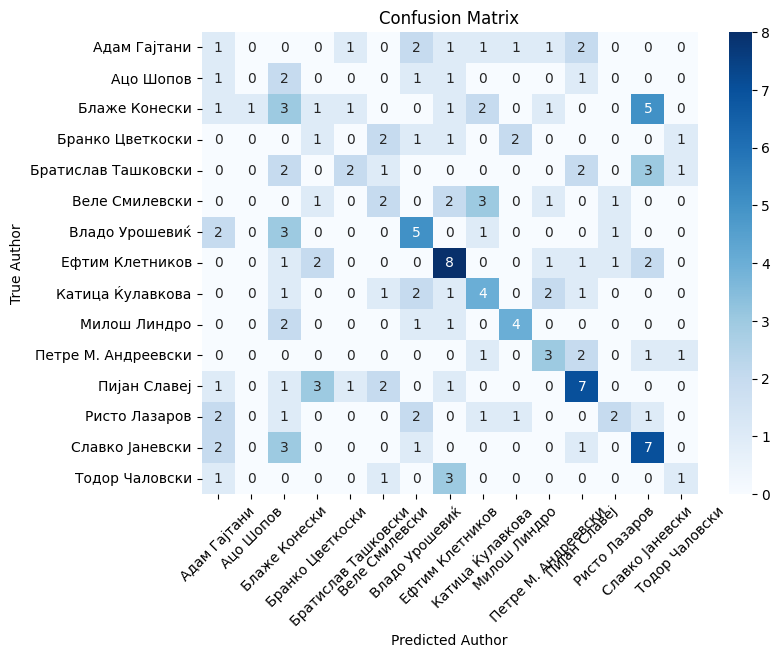

In [40]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

def generate_feature_vectors(df):
    features = []
    for _, row in df.iterrows():
        values = [0] * 86
        pattern = r"(.+?):\s*(.+)"
        pairs = re.findall(pattern, row['extracted_styles'])
        for i, (key, value) in enumerate(pairs):
            if i >= 86:
                break
            if value.strip().lower().startswith("да"):
                values[i] = 1
        features.append(values)
    return np.array(features)

def objective(trial, database):
    if not isinstance(database, pd.DataFrame) or 'author' not in database.columns:
        print("Error: 'author' column not found or invalid DataFrame")
        return 0
    min_songs = trial.suggest_int("min_songs", 5, 30)
    max_songs = trial.suggest_int("max_songs", min_songs, 200)
    filtered = database.groupby('author').filter(lambda x: len(x) >= min_songs)
    if filtered['author'].nunique() < 2:
        return 0
    limited_df = filtered.groupby('author').apply(
        lambda x: x.sample(n=min(len(x), max_songs), random_state=42)
    ).reset_index(drop=True)
    X = generate_feature_vectors(limited_df)
    y = LabelEncoder().fit_transform(limited_df['author'])
    if len(X) < 2 * len(np.unique(y)):
        return 0
    test_size = max(0.2, len(np.unique(y)) / len(X))
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'eval_metric': 'mlogloss',
        'random_state': 47
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

def main(database):
    if not isinstance(database, pd.DataFrame) or 'author' not in database.columns:
        print("Error: 'author' column not found or invalid DataFrame")
        return
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, database), n_trials=100)
    print("Best parameters:", study.best_params)
    best_min = study.best_params['min_songs']
    best_max = study.best_params['max_songs']
    filtered = database.groupby('author').filter(lambda x: len(x) >= best_min)
    limited_df = filtered.groupby('author').apply(
        lambda x: x.sample(n=min(len(x), best_max), random_state=47)
    ).reset_index(drop=True)
    X = generate_feature_vectors(limited_df)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(limited_df['author'])
    if len(X) < 2 * len(np.unique(y)):
        print("Not enough samples for stratification.")
        return
    test_size = max(0.2, len(np.unique(y)) / len(X))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    best_params = {k: v for k, v in study.best_params.items() if k not in ['min_songs', 'max_songs']}
    best_params.update({'eval_metric': 'mlogloss', 'random_state': 47})
    model = XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    cm = confusion_matrix(y_test, y_pred)
    author_labels = label_encoder.inverse_transform(np.unique(y_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=author_labels, yticklabels=author_labels)
    plt.xlabel("Predicted Author")
    plt.ylabel("True Author")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
main(database)

[I 2025-10-15 19:43:03,623] A new study created in memory with name: no-name-d0957ee0-bb2b-438d-9a69-5ea1d794b2a6
/tmp/ipykernel_204546/3583557572.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  limited_df = filtered.groupby('author').apply(
/home/ivan/Desktop/Diplomska/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/home/ivan/Desktop/Diplomska/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None

Best parameters: {'min_songs': 28, 'max_songs': 83, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0017952615909783936, 'alpha': 0.00029141079415135723, 'max_iter': 201}


/home/ivan/Desktop/Diplomska/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (201) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.2545454545454545
Macro F1 Score: 0.22634554510715504


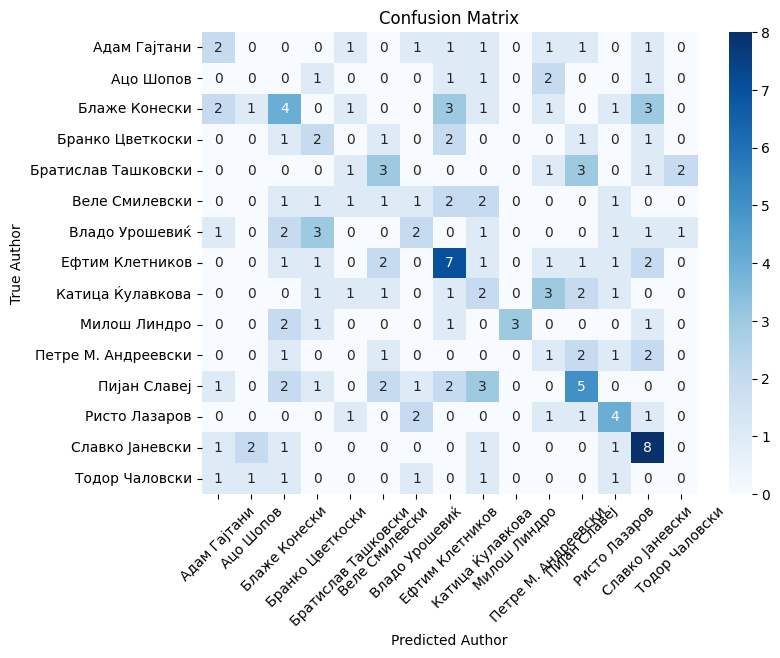

In [41]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

def generate_feature_vectors(df):
    features = []
    for _, row in df.iterrows():
        values = [0] * 86
        pattern = r"(.+?):\s*(.+)"
        pairs = re.findall(pattern, row['extracted_styles'])
        for i, (key, value) in enumerate(pairs):
            if i >= 86:
                break
            if value.strip().lower().startswith("да"):
                values[i] = 1
        features.append(values)
    return np.array(features)

def objective(trial, database):
    if not isinstance(database, pd.DataFrame) or 'author' not in database.columns:
        print("Error: 'author' column not found or invalid DataFrame")
        return 0
    min_songs = trial.suggest_int("min_songs", 5, 30)
    max_songs = trial.suggest_int("max_songs", min_songs, 200)
    filtered = database.groupby('author').filter(lambda x: len(x) >= min_songs)
    if filtered['author'].nunique() < 2:
        return 0
    limited_df = filtered.groupby('author').apply(
        lambda x: x.sample(n=min(len(x), max_songs), random_state=42)
    ).reset_index(drop=True)
    X = generate_feature_vectors(limited_df)
    y = LabelEncoder().fit_transform(limited_df['author'])
    if len(X) < 2 * len(np.unique(y)):
        return 0
    test_size = max(0.2, len(np.unique(y)) / len(X))
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        'max_iter': trial.suggest_int('max_iter', 200, 1000),
        'random_state': 47
    }
    model = MLPClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

def main(database):
    if not isinstance(database, pd.DataFrame) or 'author' not in database.columns:
        print("Error: 'author' column not found or invalid DataFrame")
        return
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, database), n_trials=100)
    print("Best parameters:", study.best_params)
    best_min = study.best_params['min_songs']
    best_max = study.best_params['max_songs']
    filtered = database.groupby('author').filter(lambda x: len(x) >= best_min)
    limited_df = filtered.groupby('author').apply(
        lambda x: x.sample(n=min(len(x), best_max), random_state=47)
    ).reset_index(drop=True)
    X = generate_feature_vectors(limited_df)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(limited_df['author'])
    if len(X) < 2 * len(np.unique(y)):
        print("Not enough samples for stratification.")
        return
    test_size = max(0.2, len(np.unique(y)) / len(X))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    best_params = {k: v for k, v in study.best_params.items() if k not in ['min_songs', 'max_songs']}
    best_params.update({'random_state': 47})
    model = MLPClassifier(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    cm = confusion_matrix(y_test, y_pred)
    author_labels = label_encoder.inverse_transform(np.unique(y_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=author_labels, yticklabels=author_labels)
    plt.xlabel("Predicted Author")
    plt.ylabel("True Author")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
main(database)